### О задании

Проблемой короновируса COVID-19, беспокоившего весь мир на протяжении последних нескольких лет, занимались и занимаются ученые по всему миру. В стороне не осталось и комьюнити Data scientist-ов, которые не только пытались в момент пандемии предсказать ее развитие, но также старались помочь определить наиболее значимые факторы, влияющие на распространение заразы. Например на небезызвестном [Kaggle](https://www.kaggle.com/tags/covid19).

В данном задании вы попрактикуетесь в анализе и прогнозировании временных рядов, работая с ежедневно обновлявшимися во время пандемии данными из [репозитория](https://github.com/datasets/covid-19), а конкретно [time-series-19-covid-combined.csv](https://github.com/datasets/covid-19/blob/master/data/time-series-19-covid-combined.csv).

Вам предстоит изучить имеющиеся данные, попробовать найти некоторые закономерности и ответить на вопросы. Ниже представлены задания как исследовательского характера, где приветствуется инициативность, так и чисто тренировочного характера - где необходимо использовать изученные на семинаре инструменты для работы с временными рядами. **Не забывайте сопровождать ваш код развернутыми комментариями и выводами.** Чем их больше и чем они качественнее, тем лучше и выше вероятность получения максимальной оценки за задание. Не болейте!

In [1]:
# !pip install orbit-ml
# !pip install orbit
# !pip install prophet
# !pip install sktime[all_extras]

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sma
import statsmodels.formula.api as smfa
import statsmodels.tsa.stattools as smstt
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [3]:
df = pd.read_csv('time-series-19-covid-combined.csv')
df.tail()

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths
231739,2022-04-12,Zimbabwe,NaN,247094,0.00,5460
231740,2022-04-13,Zimbabwe,NaN,247160,0.00,5460
231741,2022-04-14,Zimbabwe,NaN,247208,0.00,5462
231742,2022-04-15,Zimbabwe,NaN,247237,0.00,5462
231743,2022-04-16,Zimbabwe,NaN,247237,0.00,5462


## Раздел 1. Первичный анализ временных рядов (45 баллов и 15 бонусных баллов)

#### 1.1. (5 баллов) 

Определите границы исследуемого периода, количество заболевших, погибших, выздоровивших. Отобразите на карте распространение болезни. Что вы видите? Какие выводы можно сделать?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231744 entries, 0 to 231743
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            231744 non-null  object 
 1   Country/Region  231744 non-null  object 
 2   Province/State  72624 non-null   object 
 3   Confirmed       231744 non-null  int64  
 4   Recovered       218688 non-null  float64
 5   Deaths          231744 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 10.6+ MB


In [5]:
df.Date=pd.to_datetime(df.Date)
print(f'начало {df.Date.max()}, конец {df.Date.min()}, Период {df.Date.max()-df.Date.min()}')

начало 2022-04-16 00:00:00, конец 2020-01-22 00:00:00, Период 815 days 00:00:00


In [6]:
print(f'количество заболевших {df.groupby("Country/Region")["Confirmed"].max().sum()}')

количество заболевших 496679936


In [7]:
print(f'количество погибших {df.groupby("Country/Region")["Deaths"].max().sum()}')

количество погибших 6159555


In [8]:
print(f'количество выздоровевших {df.groupby("Country/Region")["Recovered"].max().sum()}')

количество выздоровевших 135699576.0


In [9]:
# map

#### 1.2. (5 баллов)

Определите количество стран, которые подтвердили случаи заражения 
- на 1 марта 2020 года
- на 1 июня 2020 года
- на 1 октября 2020 года
- на 1 января 2021 года
- на 1 января 2022 года
- на момент окончания исследуемого периода.

Визуализируйте рост количества стран, подтвердивших случаи заражения
- по дням 
- по неделям
- по месяцам. 


Какие выводы можно сделать из этих графиков?

  *Примечание. В анализе временных рядов иногда необходимо изменить частоту дискретизации (Resampling). Такая операция может понадобится, когда имеющихся данных недостаточно или их, наоборот, слишком много. Может не устраивать имеющаяся частота или просто хочется посмотреть на данные с более общего ракурса.*

  *Различают два вида изменения частоты: повышение (Upsampling) и понижение (Downsampling). При повышении временной ряд пересчитывается с низкой частоы на более высокую частоту (например от годовой до месячной частоты). В таком случае процесс включает в себя заполнение или интерполяцию появившихся пропусков в данных. При понижении временной ряд передискретизируется с высокой частоты на низкую (наример с еженедельной на месячную частоту). Это включает в себя агрегацию существующих данных.*

In [10]:
print(f'на 1 марта 2020 года: {df[(df.Date<"2020-03-01") & (df.Confirmed>0)]["Country/Region"].nunique()}')
print(f'на 1 июня 2020 года: {df[(df.Date<"2020-06-01") & (df.Confirmed>0)]["Country/Region"].nunique()}')
print(f'на 1 октября 2020 года: {df[(df.Date<"2020-10-01") & (df.Confirmed>0)]["Country/Region"].nunique()}')
print(f'на 1 января 2021 года: {df[(df.Date<"2021-01-01") & (df.Confirmed>0)]["Country/Region"].nunique()}')
print(f'на 1 января 2022 года: {df[(df.Date<"2022-01-01") & (df.Confirmed>0)]["Country/Region"].nunique()}')
print(f'на момент окончания исследуемого периода: {df[df.Confirmed>0]["Country/Region"].nunique()}')

на 1 марта 2020 года: 62
на 1 июня 2020 года: 187
на 1 октября 2020 года: 187
на 1 января 2021 года: 191
на 1 января 2022 года: 197
на момент окончания исследуемого периода: 198


In [11]:
def funx(date_):
    return df[(df.Date<date_) & (df.Confirmed>0)]["Country/Region"].nunique()

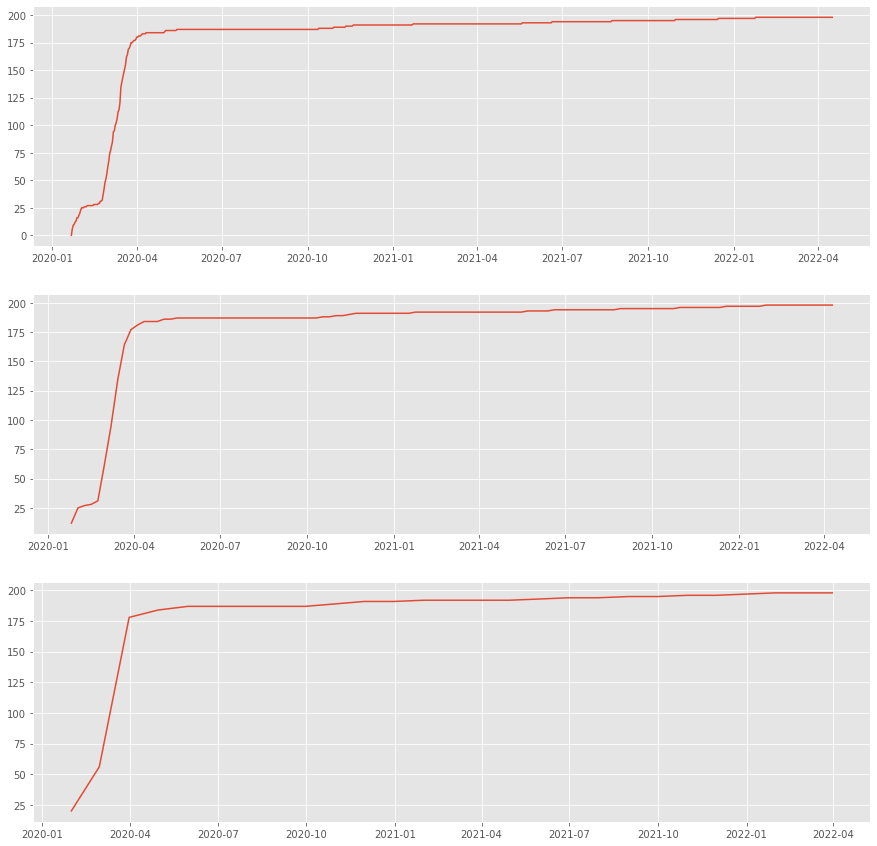

In [12]:
x=pd.date_range(start=df.Date.min(), end=df.Date.max())
y=[funx(x_) for x_ in x]
x_w=pd.date_range(start=df.Date.min(), end=df.Date.max(), freq='W')
y_w=[funx(x_) for x_ in x_w]
x_m=pd.date_range(start=df.Date.min(), end=df.Date.max(), freq='M')
y_m=[funx(x_) for x_ in x_m]
fig, axs = plt.subplots(3)
axs[0].plot(x, y)
axs[1].plot(x_w, y_w)
axs[2].plot(x_m, y_m)

#### 1.3. (5 баллов)

Визуализируйте мировые тренды по числу 

- заболевших 
- погибших 
- выздоровивших.

Постройте графики, которые отражают летальность от вируса 

- в разных странах 
- на разных континентах. 

Какие выводы можно сделать?

Для исследования летальности на разных континетах потребуется ввести новые данные. 

In [13]:
df_world=pd.read_csv('world_population.csv')
df_world=df_world[['Country/Territory', 'Continent', '2022 Population']]
df_world=df_world.rename(columns={"Country/Territory": "Country/Region", "2022 Population": "Population"})
df = pd.merge(df, df_world, how="left", on=["Country/Region"])
df.head(2)

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths,Continent,Population
0,2020-01-22,Afghanistan,NaN,0,0.00,0,Asia,41128771.00
1,2020-01-23,Afghanistan,NaN,0,0.00,0,Asia,41128771.00


In [14]:
df_world.loc[df_world['Country/Region']=='United States', 'Country/Region'] = 'US'

In [15]:
df_dates=df.groupby('Date').sum()

x=[x_ for x_ in range(df_dates.shape[0])]

def trends(target):
    y=df_dates[target]
    plt.plot(x, y)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.title(target)
    plt.plot(x, p(x), label='trend')
    plt.legend()

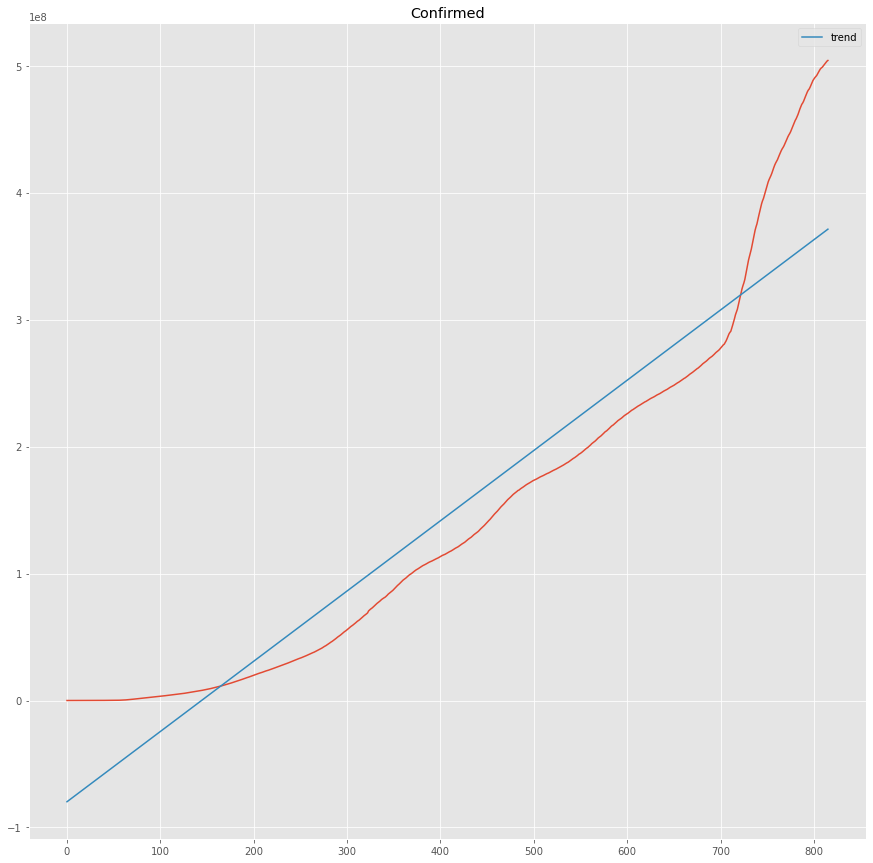

In [16]:
trends('Confirmed')

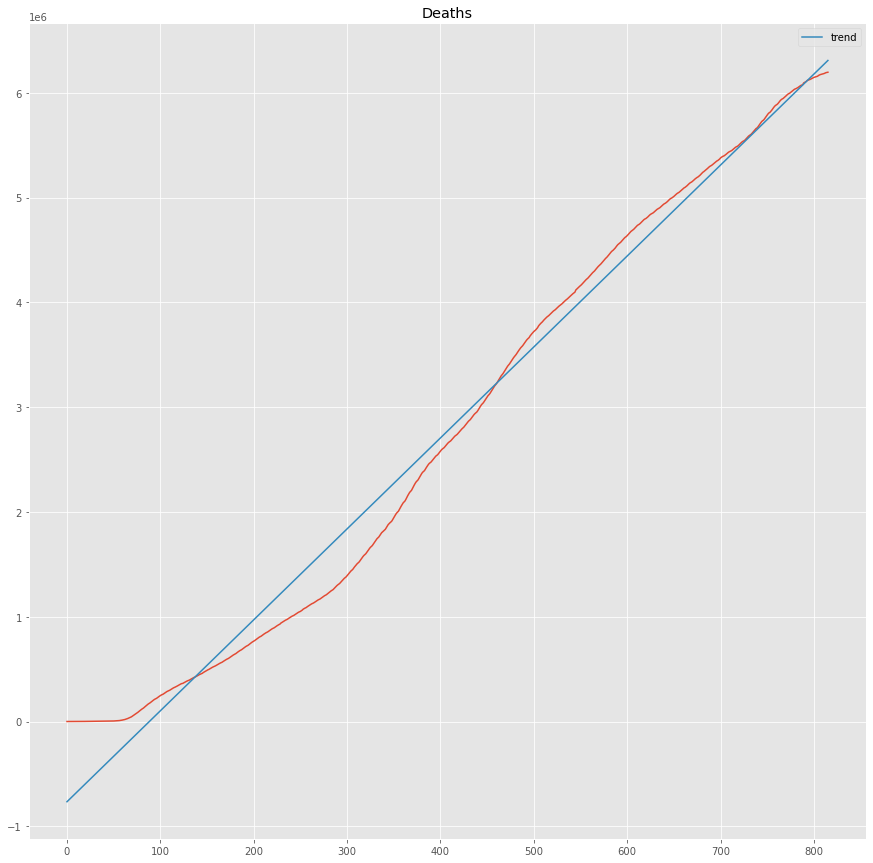

In [17]:
trends('Deaths')

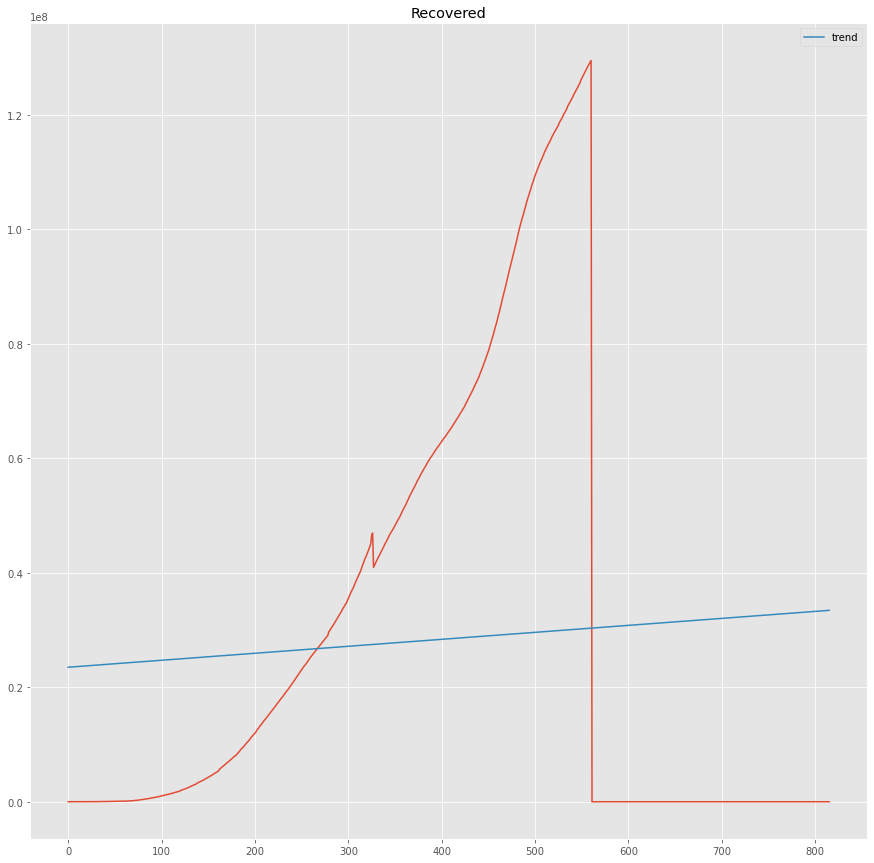

In [18]:
trends('Recovered')

Летальность по странам (топ 10) в виде столбчатой диаграммы


<AxesSubplot:xlabel='Country/Region'>

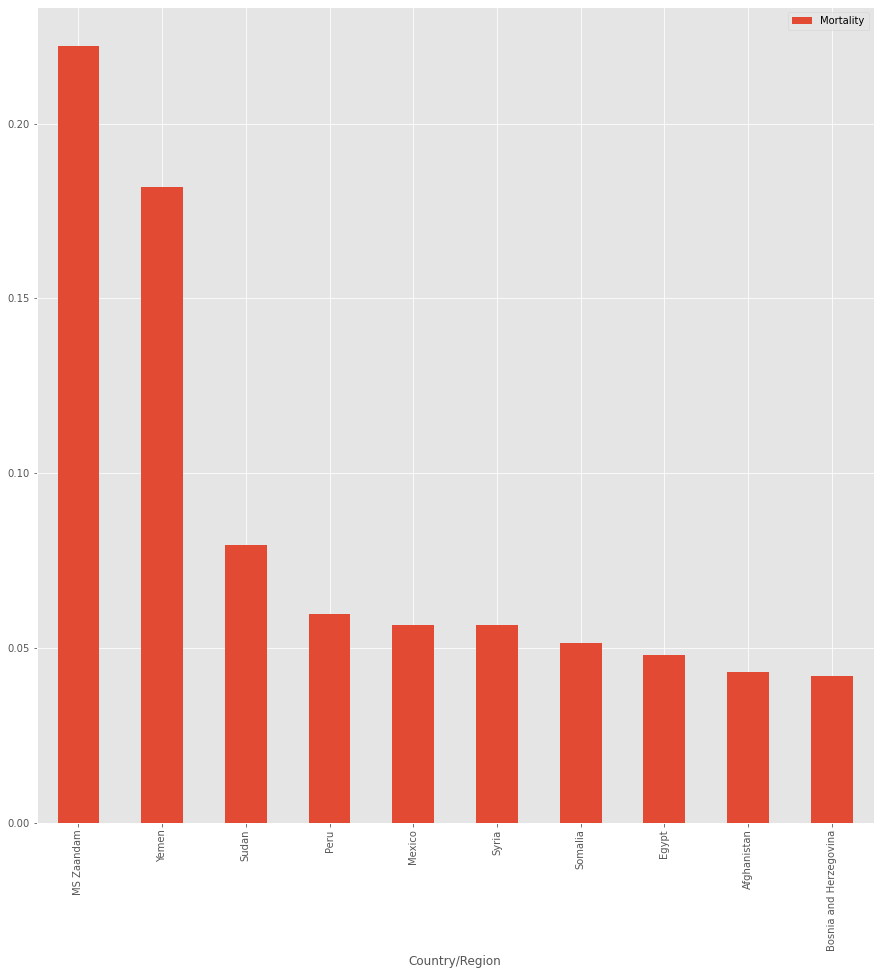

In [19]:
df1=df[df['Date']==df['Date'].max()].groupby('Country/Region').sum()
df1['Mortality']=df1['Deaths']/df1['Confirmed']
print('Летальность по странам (топ 10) в виде столбчатой диаграммы')
df1.sort_values(by=['Mortality'], ascending=False)[:10].plot.bar(y='Mortality')

Скорее всего в странах с самой высокой смертностью плохо высчитывался показатель confirmed.

#### 1.4. (5 баллов)

Визуализируйте и сравните, как распространялась болезнь в разных странах и на разных континентах по дням с первого зарегистрированного случая заболевания. Определите количество дней для каждой страны со дня первого зарегестрированного случая. Какие тенденции вы видите?

In [20]:
#Дата первого случая
first_incid=df[df['Confirmed']>0]['Date'].min()
#Распространение по странам со дня первого случая
list_after=df[df['Confirmed']!=0].groupby("Country/Region")["Date"].min()-first_incid
list_after.sort_values(ascending=True)

Country/Region
China                    0 days
US                       0 days
Thailand                 0 days
Taiwan*                  0 days
Japan                    0 days
                         ...   
Summer Olympics 2020   514 days
Palau                  578 days
Tonga                  646 days
Antarctica             692 days
Winter Olympics 2022   732 days
Name: Date, Length: 198, dtype: timedelta64[ns]

Очевидно, что самые развитые и густонаселенные страны первыми столкнулись с ковидом.

#### 1.5. (5 баллов)

Визуализируйте и оцените как развивалась ситуация в России по сравнению с остальными миром. Как вы будете осуществлять сравнение? Почему? Какие выводы можно сделать?

Предполагается, что по оси y будет 2 оси ординат: одна для России, вторая для остального мира.

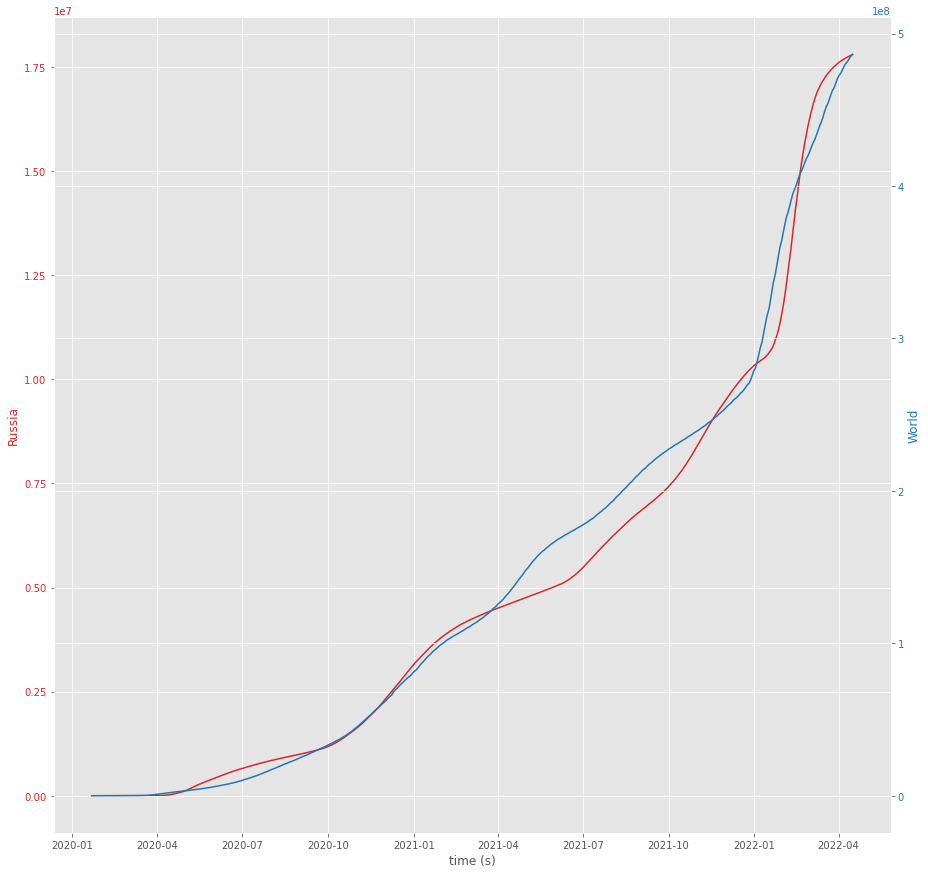

In [21]:
x=df['Date'].unique()
y_russia=df[df['Country/Region']=='Russia']['Confirmed']
y_world=df[df['Country/Region']!='Russia'].groupby('Date')["Confirmed"].sum().tolist()
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Russia', color=color)
ax1.plot(x, y_russia, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('World', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y_world, color=color)
ax2.tick_params(axis='y', labelcolor=color)

Глядя на графики, можно сказать, что в России ковид распространялся примерно как во всём мире. Мировой график выглядит более гладким, предположительно в России были относительно чётко обозначенные волны заболеваемости.

#### 1.6. (5 баллов)

Определите топ-10 стран, которые лидируют по имеющимся в датасете показателям. Постоянны ли эти лидеры? За какой временной промежуток было бы наиболее правильно брать лидеров, на ваш взгляд? Почему? Сравните насколько быстро развивается ситуация в этих странах. Определите корреляцию.

In [22]:
confirmed=df.groupby("Country/Region")["Confirmed"].max().sort_values(ascending=False).head(10)
print(confirmed)

Country/Region
US                80625120
India             43042097
Brazil            30250077
France            26955613
Germany           23416663
United Kingdom    21747638
Russia            17801103
Korea, South      16305752
Italy             15659835
Turkey            14991669
Name: Confirmed, dtype: int64


In [23]:
Deaths=df.groupby("Country/Region")["Deaths"].max().sort_values(ascending=False).head(10)
print(Deaths)

Country/Region
US                988609
Brazil            662185
India             521751
Russia            365774
Mexico            323938
Peru              212619
United Kingdom    171396
Italy             161602
Indonesia         155844
France            140952
Name: Deaths, dtype: int64


In [24]:
Recovered=df.groupby("Country/Region")["Recovered"].max().sort_values(ascending=False).head(10)
print(Recovered)

Country/Region
India       30974748.00
Brazil      17771228.00
US           6298082.00
Russia       5609682.00
Turkey       5478185.00
Argentina    4615834.00
Colombia     4615354.00
Italy        4144608.00
Germany      3659260.00
Iran         3444798.00
Name: Recovered, dtype: float64


In [25]:
df1.Mortality.head(10)

Country/Region
Afghanistan           0.04
Albania               0.01
Algeria               0.03
Andorra               0.00
Angola                0.02
Antarctica            0.00
Antigua and Barbuda   0.02
Argentina             0.01
Armenia               0.02
Australia             0.00
Name: Mortality, dtype: float64

#### 1.7. (5 баллов)

Для первых 5 стран из топ-10 из прошлого задания и России (суммарно 5 или 6 стран, в зависимости от того, входит ли Россия в топ) постройте сравнительные графики. Изучите как изменялись значения отношений 
- погибших/выздоровивших 
- погибших/заболевших 
- заболевших/общее число жителей
- еще один ваш вариант (что будет осмысленно здесь взять?)

Какие выводы можно сделать из подобного сравнения?

In [26]:
countries_list=confirmed.index[:5].to_list()
countries_list.append('Russia')
print(countries_list)

['US', 'India', 'Brazil', 'France', 'Germany', 'Russia']


In [27]:
df6=df[df['Country/Region'].isin(countries_list)]
df6.head(2)

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths,Continent,Population
25296,2020-01-22,Brazil,NaN,0,0.00,0,South America,215313498.00
25297,2020-01-23,Brazil,NaN,0,0.00,0,South America,215313498.00


In [28]:
df6['Mortality']=df6['Deaths']/df6['Confirmed']
df6['Recoverity']=df6['Deaths']/df6['Recovered']
df6['conf_population']=df6['Confirmed']/df6['Population']
df6['mort_population']=df6['Deaths']/df6['Population']
df6 = df6.fillna(0)

In [29]:
for i in countries_list:
    print(df6[df6['Country/Region']==i].shape)

(816, 12)
(816, 12)
(816, 12)
(9792, 12)
(816, 12)
(816, 12)


У выборки разные длины. Уберем у Франции колонии.

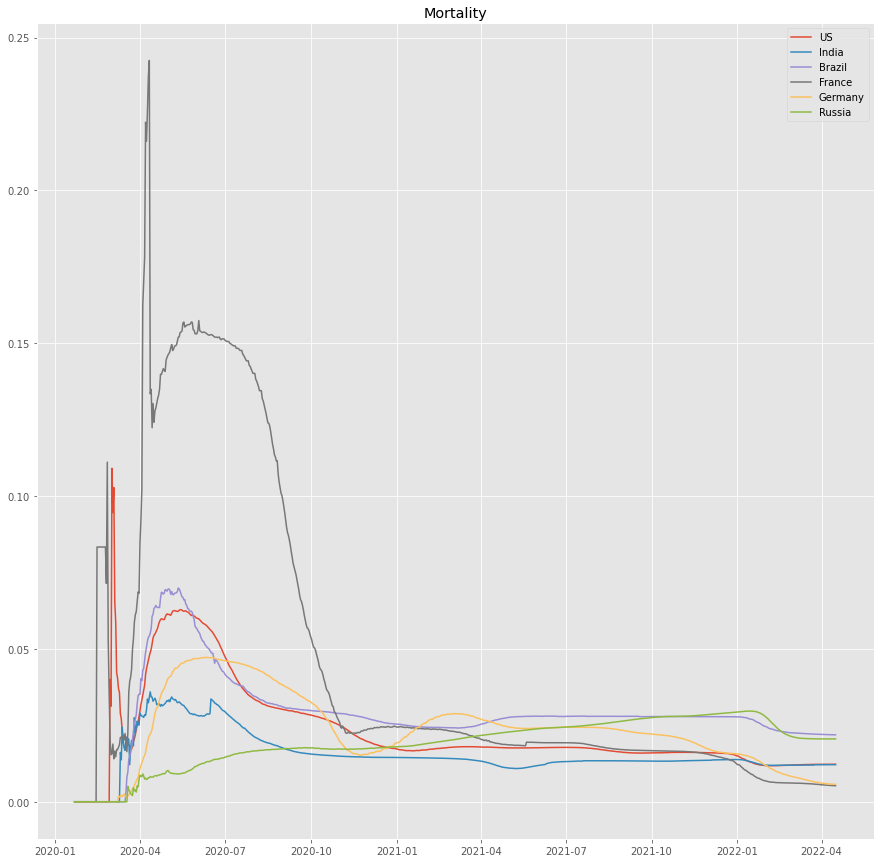

In [30]:
x=df6[df6['Country/Region']=='Germany'].Date
plt.title('Mortality')
for i in countries_list:
    #print(i)
    plt.plot(x, df6[(df6['Country/Region']==i) & (df6['Province/State']==0)]['Mortality'], label=i)
plt.legend()

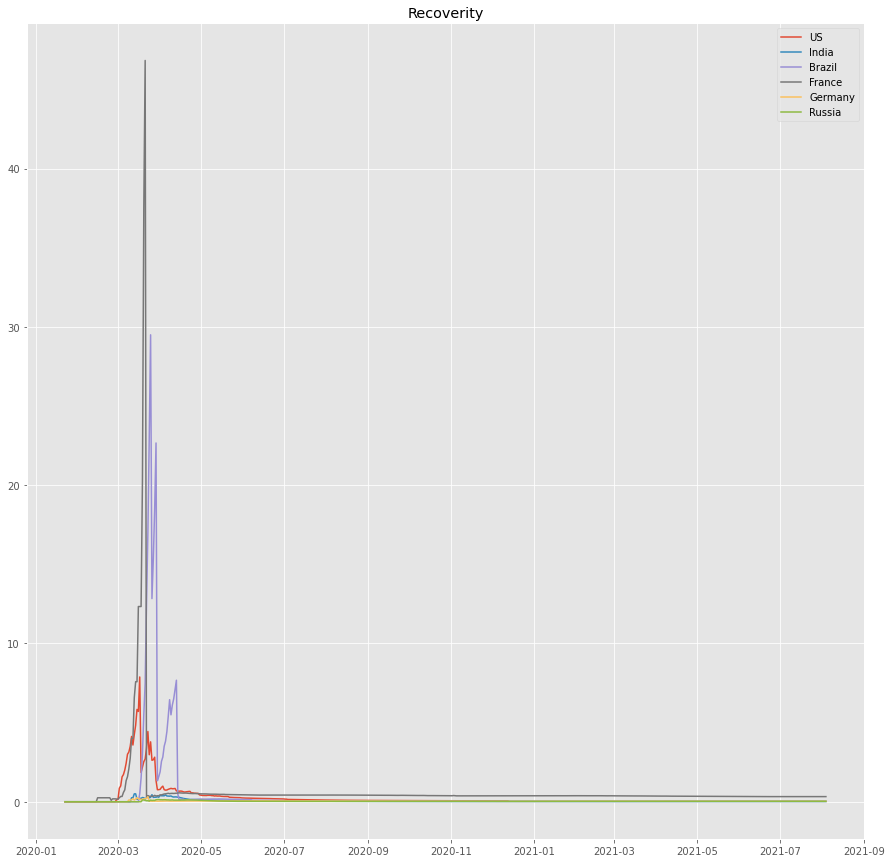

In [31]:
plt.title('Recoverity')
for i in countries_list:
    #print(i)
    plt.plot(x, df6[(df6['Country/Region']==i) & (df6['Province/State']==0)]['Recoverity'], label=i)
plt.legend()

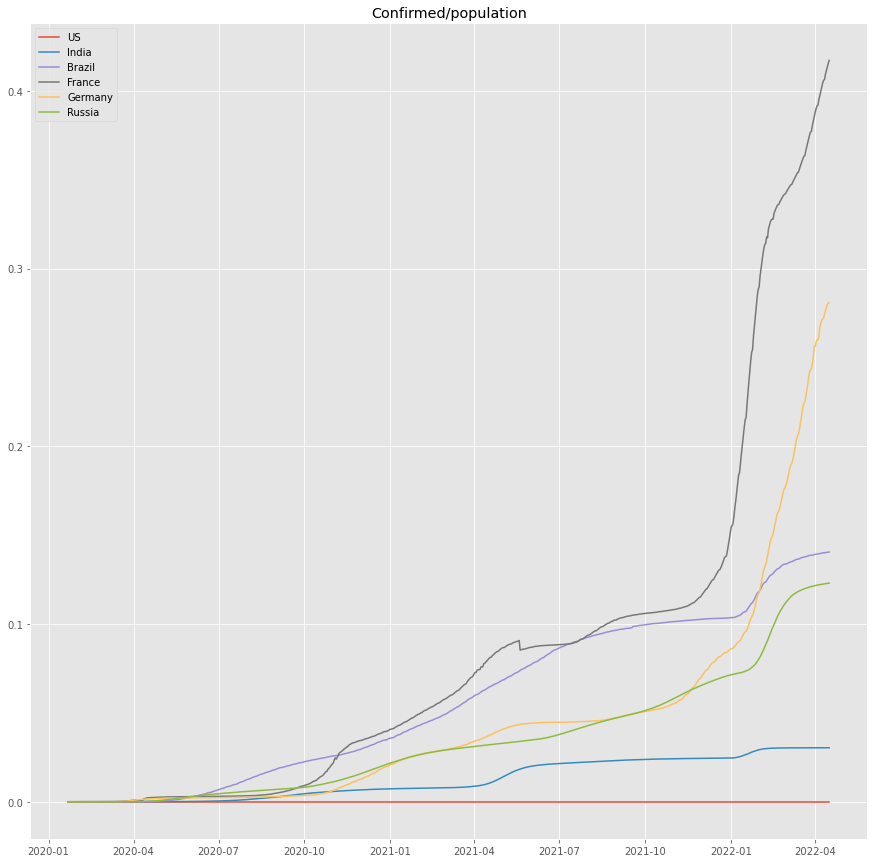

In [32]:
plt.title('Confirmed/population')
for i in countries_list:
    #print(i)
    plt.plot(x, df6[(df6['Country/Region']==i) & (df6['Province/State']==0)]['conf_population'], label=i)
plt.legend()

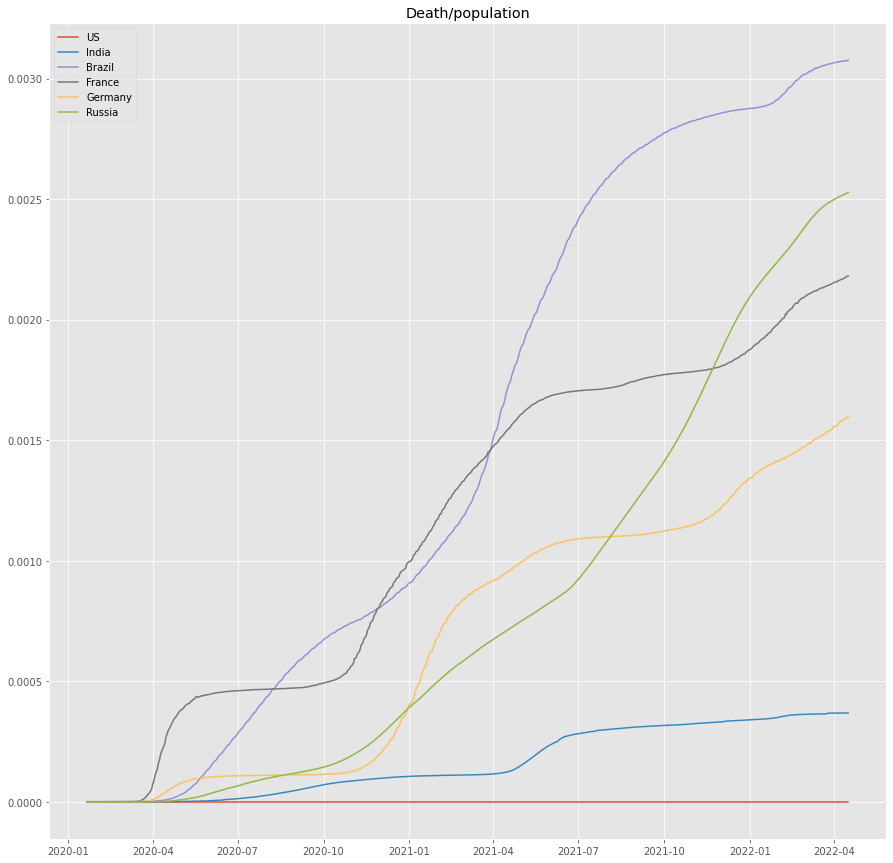

In [33]:
plt.title('Death/population')
for i in countries_list:
    plt.plot(x, df6[(df6['Country/Region']==i) & (df6['Province/State']==0)]['mort_population'], label=i)
plt.legend()

#### 1.8. (5 баллов и 15 бонусных баллов)

Изучаемый вами датасет отражает мировую статистику распространения болезни. Однако эти данные не дают нам возможности сделать предположения о возможных факторах, которые влияют на скорость распространения, летальность, заразность и тд. Поэтому в наш датасет можно добавить новые признаки из других наборов данных, которые могут не только помочь при прогнозировании временного ряда, но и определить наиболее значимые факторы.

- Добавьте новый признак "количество дней со дня первого случая заражения".
- Добавьте еще не менее 5 новых признаков в датасет, которые могут быть значимым фактором распространения вируса. Сохраните полученный датасет. Вы можете его использовать в третьей части домашнего задания (за это вы сможете получить там дополнительные бонусные баллы).
- Исследуйте, как добавленные признаки соотносятся с трендами распространения короновируса в некоторых странах. Сделайте выводы.

*Подсказка: некоторые примеры признаков (список далеко не исчерпывающий и лучше хотя бы несколько придумать своих): количество дней с начала карантина; конинент; плотность населения; количество употребляемого алкоголя; распространенность летучих мышей; количество крокодилов на душу населения; количество туристов в год; уровень безработицы; температура; количество игроков в Plague Inc.; средний возраст или продолжительность жизни; и так далее. Вы можете использовать любой найденный датасет. Главное, чтобы у Вас получилось скомбинировать данные.*

  Примеры датасетов для вас:
  1. [500 Cities: Local Data for Better Health (2019)](https://www.kaggle.com/jaimeblasco/500-cities-local-data-for-better-health-2019)
  2. [Daily global surface summary from over 9000 weather stations from 1929 to now](https://www.kaggle.com/noaa/gsod)
  3. [Population by Country - 2020](https://www.kaggle.com/tanuprabhu/population-by-country-2020)



In [34]:
first_date=df[df['Confirmed']>0].groupby('Country/Region').min()
first_date=first_date.rename(columns={"Date": "From_date"})#
first_date=first_date.reset_index()[['Country/Region', 'From_date']]
first_date

,Country/Region,From_date
0,Afghanistan,2020-02-24
1,Albania,2020-03-09
2,Algeria,2020-02-25
3,Andorra,2020-03-02
4,Angola,2020-03-20
...,...,...
193,West Bank and Gaza,2020-03-05
194,Winter Olympics 2022,2022-01-23
195,Yemen,2020-04-10
196,Zambia,2020-03-18


In [35]:
df = pd.merge(df, first_date, how="left", on=["Country/Region"])
df

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths,Continent,Population,From_date
0,2020-01-22,Afghanistan,NaN,0,0.00,0,Asia,41128771.00,2020-02-24
1,2020-01-23,Afghanistan,NaN,0,0.00,0,Asia,41128771.00,2020-02-24
2,2020-01-24,Afghanistan,NaN,0,0.00,0,Asia,41128771.00,2020-02-24
3,2020-01-25,Afghanistan,NaN,0,0.00,0,Asia,41128771.00,2020-02-24
4,2020-01-26,Afghanistan,NaN,0,0.00,0,Asia,41128771.00,2020-02-24
...,...,...,...,...,...,...,...,...,...
231739,2022-04-12,Zimbabwe,NaN,247094,0.00,5460,Africa,16320537.00,2020-03-20
231740,2022-04-13,Zimbabwe,NaN,247160,0.00,5460,Africa,16320537.00,2020-03-20
231741,2022-04-14,Zimbabwe,NaN,247208,0.00,5462,Africa,16320537.00,2020-03-20
231742,2022-04-15,Zimbabwe,NaN,247237,0.00,5462,Africa,16320537.00,2020-03-20


In [36]:
df['From_date']=df['Date']-df['From_date']

In [37]:
df.loc[df['From_date']<'0 day', 'From_date']=0
df

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths,Continent,Population,From_date
0,2020-01-22,Afghanistan,NaN,0,0.00,0,Asia,41128771.00,0
1,2020-01-23,Afghanistan,NaN,0,0.00,0,Asia,41128771.00,0
2,2020-01-24,Afghanistan,NaN,0,0.00,0,Asia,41128771.00,0
3,2020-01-25,Afghanistan,NaN,0,0.00,0,Asia,41128771.00,0
4,2020-01-26,Afghanistan,NaN,0,0.00,0,Asia,41128771.00,0
...,...,...,...,...,...,...,...,...,...
231739,2022-04-12,Zimbabwe,NaN,247094,0.00,5460,Africa,16320537.00,753 days 00:00:00
231740,2022-04-13,Zimbabwe,NaN,247160,0.00,5460,Africa,16320537.00,754 days 00:00:00
231741,2022-04-14,Zimbabwe,NaN,247208,0.00,5462,Africa,16320537.00,755 days 00:00:00
231742,2022-04-15,Zimbabwe,NaN,247237,0.00,5462,Africa,16320537.00,756 days 00:00:00


#### 1.9. (5 баллов)

Какие закономерности и тенденции бросились вам в глаза в ходе проделанного в разделе 1 анализа? Что оказалось неожиданным, а что, наоборот, ожидаемым? Почему? Напишите итоговые выводы по проделанному вами первичному анализу данных в рамках данного раздела.

### Выводы
Нельзя полагаться на адекватную статистику по самым бедным странам. Они будут лидерами по смертности во многом из-за малого числа зафиксированных случаев.

Большая часть стран заимела первого заболевшего в первые 3-4 месяца. Полагаю, что дальнейшие карантинные мерояприятия были избыточны. Т.е. для победы над ковидом имело смысл вводить серьёзные карантинные мероприятия в первые три месяца.

В России и Бразилии высокие показатели  смертности. Возможно, это связано неблагоприятной социально-экономической ситуацией в этих странах.

## Раздел 2. Статистический анализ и подготовка данных (28 баллов)


#### 2.1. (5 баллов)

В рамках задачи исследования и прогнозирования тенденций развития пандемии коронавируса, не очень интересно предсказывать количество заболевших/умерших к моменту окончания исследуемого периода данного датасета, поскольку все изменения значений будут близки к нулю - пандемия фактически уже окончилась. Какой в таком случае конец "известного" периода имело бы смысл взять? 

Также, с другой стороны: все ли данные от начала пандемии нам необходимы и полезны для анализа и прогнозирования? Почему? Обрежьте наш датасет с конца и (если необходимо) с начала, выделив тем самым интересующий нас рабочий период для анализа. Обязательно аргументируйте, почему вы решили взять период именно таким. Обрезку, на всякий случай, осуществляйте в копии датасета и сохраните исходный датасет на случай необходимости дополнительного анализа/анализа на других временных интервалах.

<AxesSubplot:xlabel='Date'>

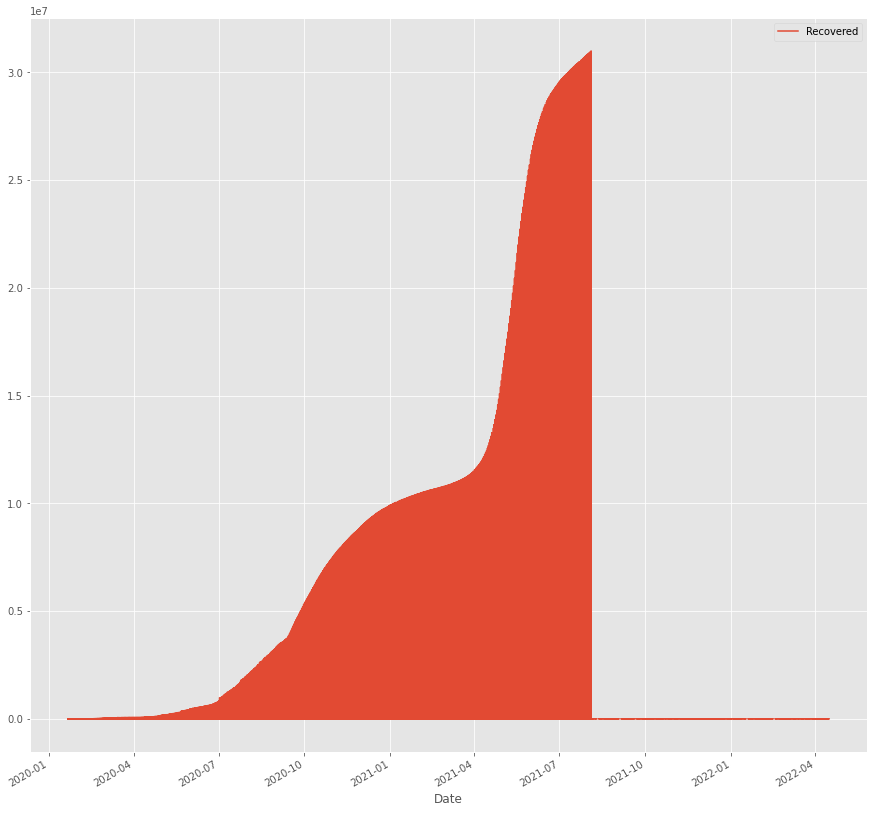

In [38]:
df.plot(x='Date', y='Recovered')

In [39]:
df.to_csv('after_part1.csv')

Возьмём данные с 2020-04-01 по 2021-08-01. Судя по графику выше, в этом период пандемия имела место в большинстве стран.

In [40]:
df=df[(df['Date']>='2020-04-01') & (df['Date']<='2021-08-01')]
df=df.drop(['Province/State'], axis=1)

#### 2.2. (10 баллов)

Выделите временной ряд по одному из имеющихся у нас целевых признаков на ваш выбор. Для выделенного временного ряда проведите простой статистический анализ:

- Рассчитайте несколько первых лагов для временного ряда, выведите их на графике.
- Представьте временной ряд в виде последовательности разниц между значениями и визуализируйте её. Представьте его также в виде последовательности разниц разниц. Визуализируйте и это.
- Перейдите от временного ряда к логарифму временного ряда. Визуализируйте полученный ряд. Что можно сказать об изменениях?
- Осуществите декомпозицию временного ряда (тренд, сезонность, резидуалс). Постройте график тренда отдельно и график тренда на тех же осях, что и исходный временной ряд. Повторите проделанные действия для логарифма временного ряда. Имеется ли разница?
- Что вы можете сказать о стационарности временного ряда? Почему? Осуществите проверку на стационарность (желательно, с использованием методов математической статистики). Что можно сказать о стационарности последовательности разниц и последовательности разниц разниц? Также осуществите проверку на стационарность для этих рядов.

Какие выводы вы можете сделать из проделанного анализа?

In [41]:
df_ru=pd.DataFrame(df[df['Country/Region']=='Russia'][['Date', 'Confirmed']])
df_ru=df_ru.set_index('Date')

In [42]:
for i in range(1, 4):
    df_ru[f'conf{i}'] = df_ru['Confirmed'].diff(periods=i).dropna()
df_ru.head(2)

,Confirmed,conf1,conf2,conf3
Date,,,,
2020-04-01,2777,NaN,NaN,NaN
2020-04-02,3548,771.00,NaN,NaN


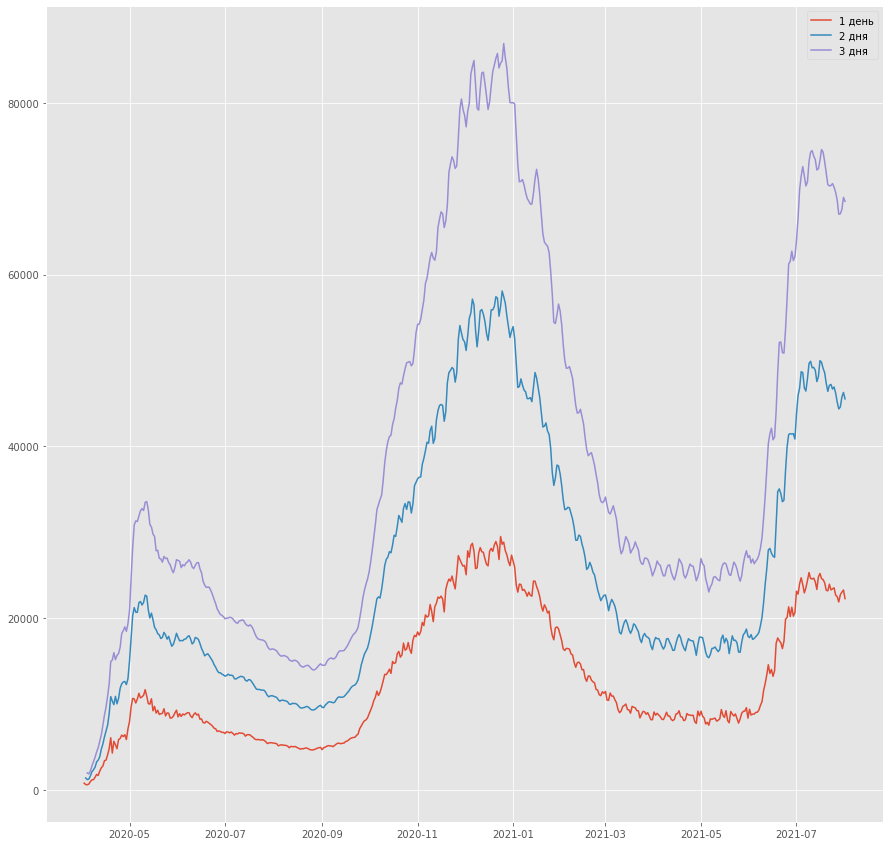

In [43]:
plt.plot(df_ru.index, df_ru['conf1'], label='1 день')
plt.plot(df_ru.index, df_ru['conf2'], label='2 дня')
plt.plot(df_ru.index, df_ru['conf3'], label='3 дня')
plt.legend()

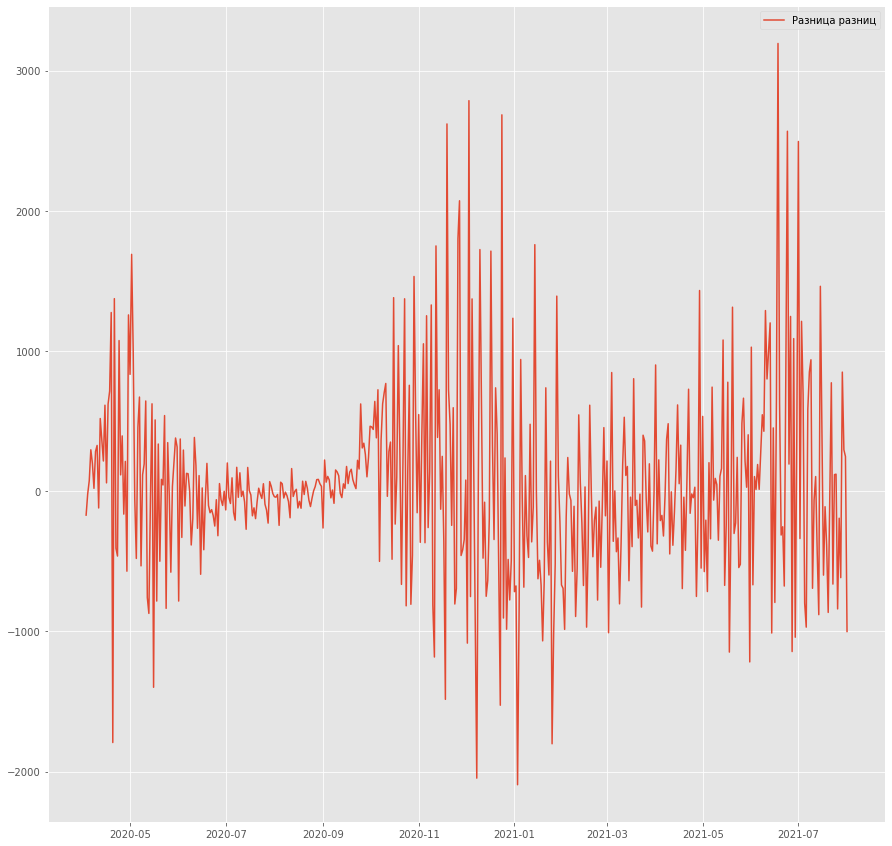

In [44]:
df_ru['2conf'] = df_ru['conf1'].diff(periods=1).dropna()
plt.plot(df_ru.index, df_ru['2conf'], label='Разница разниц')
plt.legend()

In [45]:
df_ru=df_ru.dropna()

<AxesSubplot:xlabel='Date'>

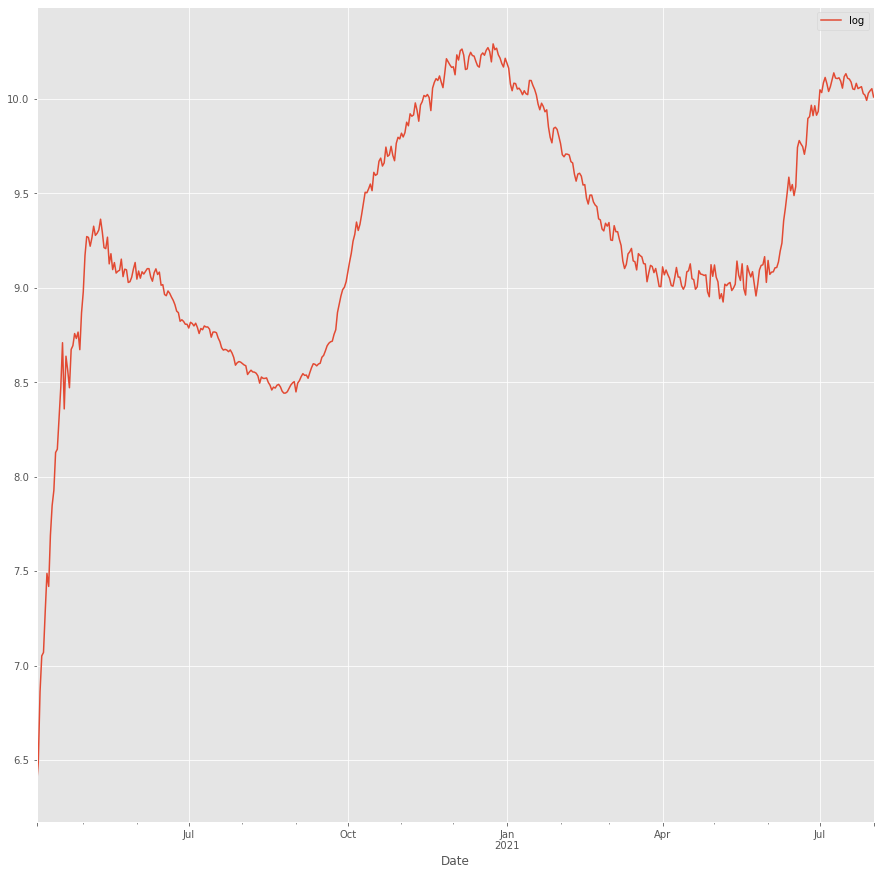

In [46]:
# Логарифм временного ряда
df_ru['log'] = np.log(df_ru['conf1'])
df_ru.plot(y='log')

Декомпозиция

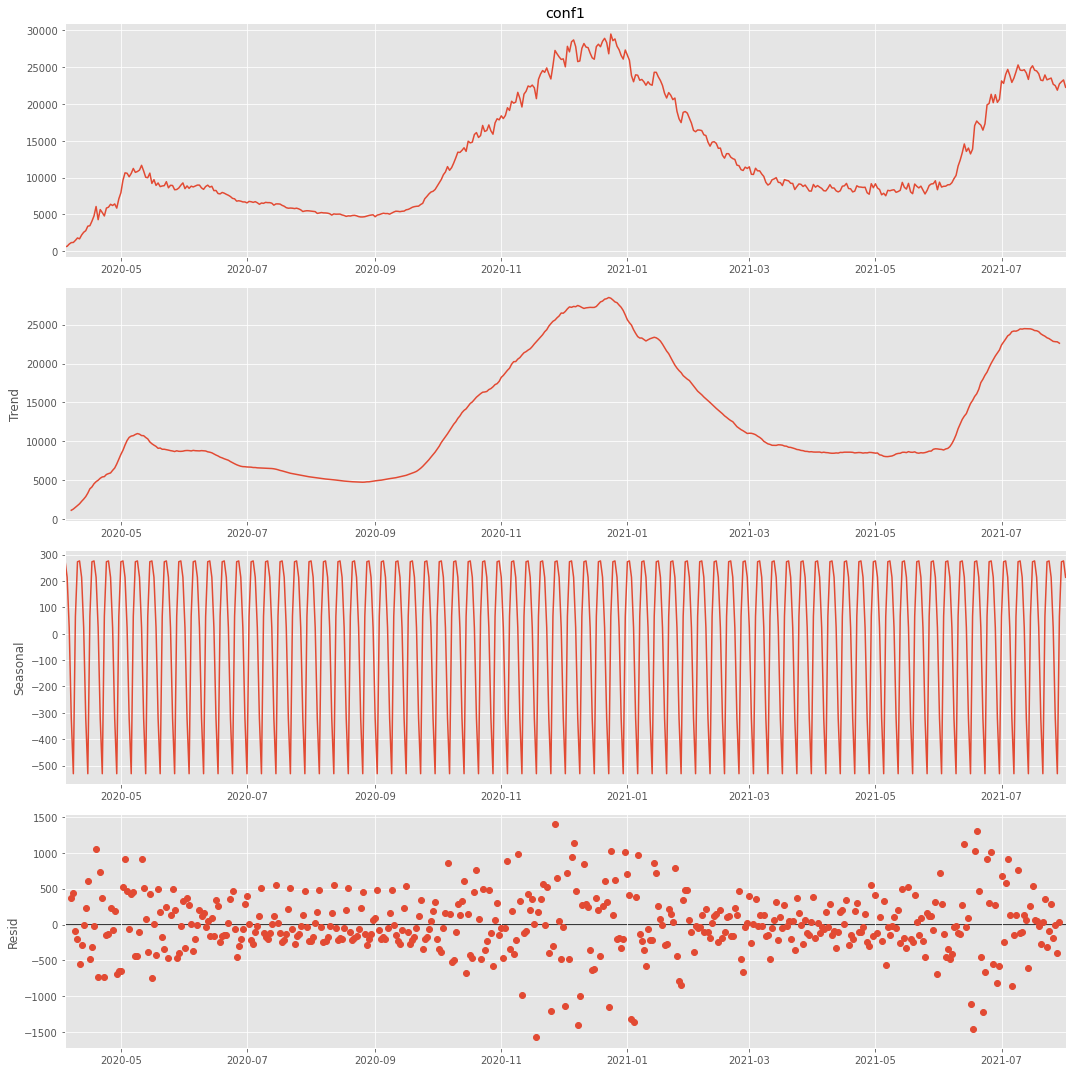

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_ru['conf1'].dropna(), model='additive')
fig = decomposition.plot()

Для логарифма временного ряда

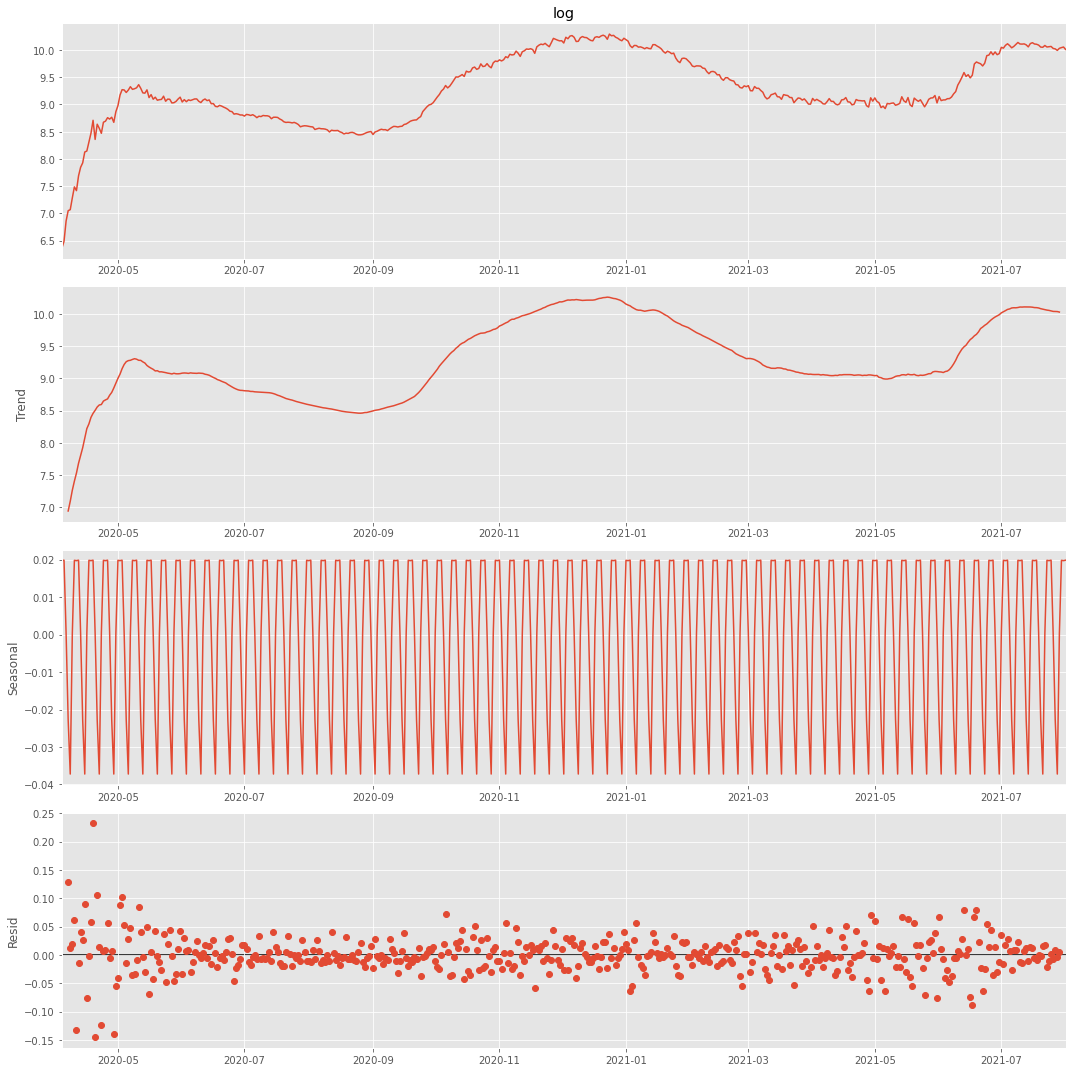

In [48]:
decomposition = seasonal_decompose(df_ru['log'].dropna(), model='additive')# period=7
fig = decomposition.plot()

Логарифмированный временной ряд имеет меньшие значения. Это облегчает настройку модели.

#### 2.3. (8 баллов)

Для выбранного вами в предыдущем задании временного ряда и еще одного любого постройте графики ACF и PACF. Что показывают эти функции и что можно увидеть на графиках? Прокомментируйте полученные результаты: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда? В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.


ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA


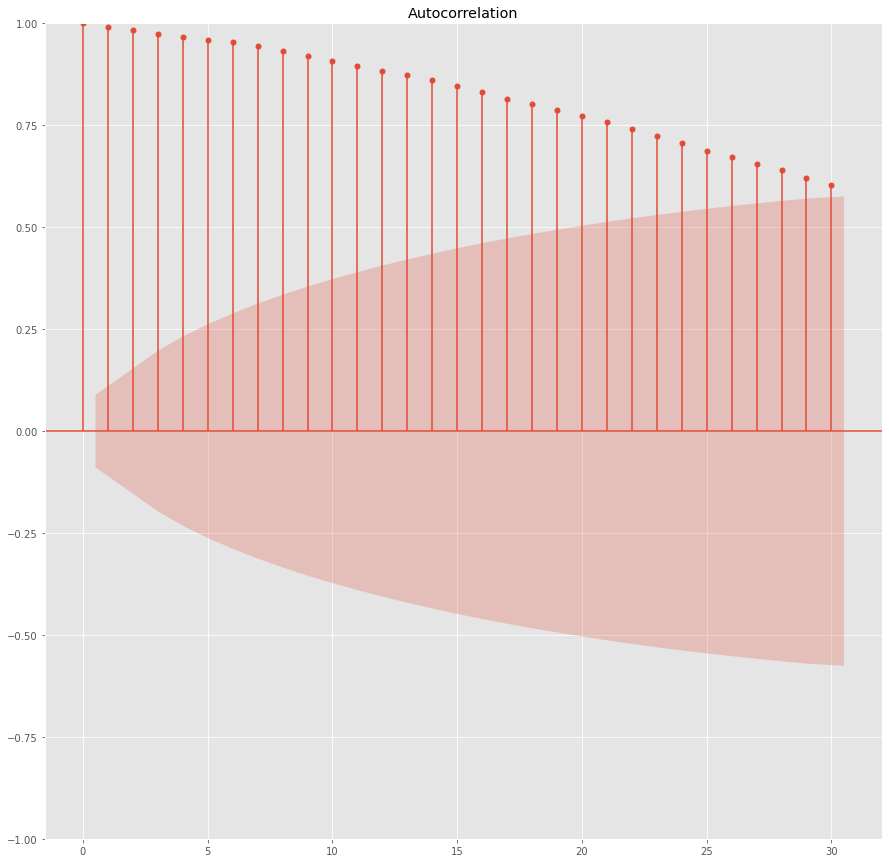

In [49]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_ru['conf1'].dropna(), lags = 30)
print('ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA')

PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.


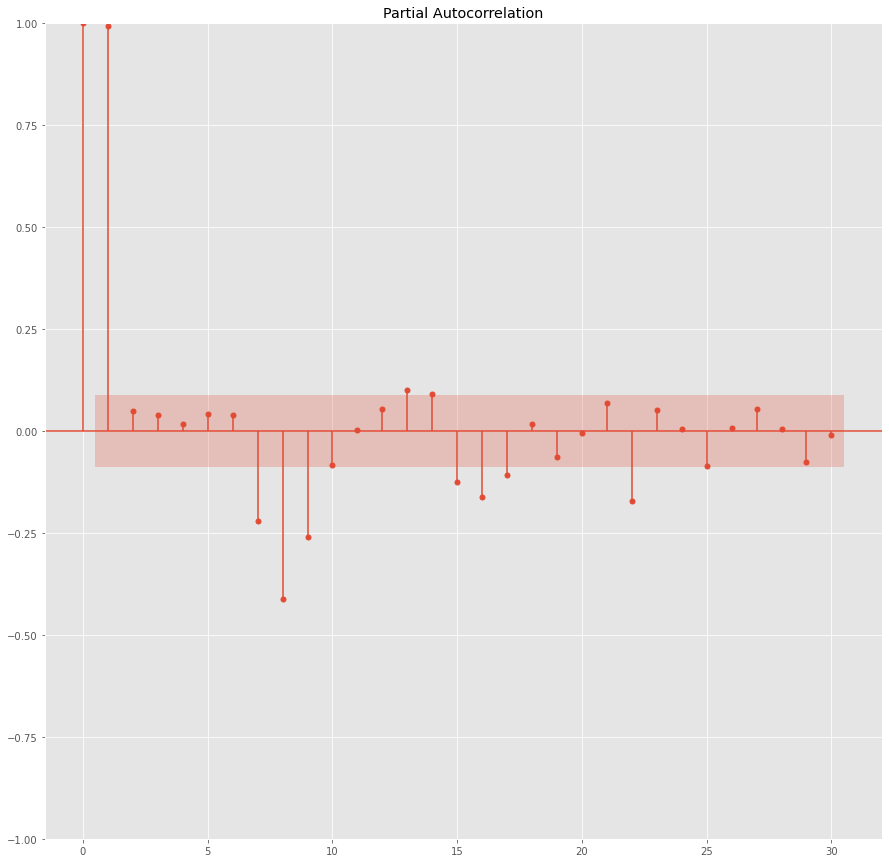

In [50]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_ru['conf1'].dropna(), lags = 30, method = "ols")
print('PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.')

#### 2.4. (5 баллов)

Вспомним, что для прогнозирования временного ряда необходимо разделить выборку на две составляющие (train и test). На составляющей train наша модель обучается и настраивает свои параметры, на составляющей test модель осуществляет предсказание (а затем мы можем это предсказание сравнить с реальными данными)

Осуществите разбиение датасета на выборку train и test. Соотношение размеров train/test на ваше усмотрение, но мы советуем вам выбрать 85% на 15% или 80% на 20% (при условии, что при этом в test остаётся не менее 20-25 наблюдений).

Отрисуйте не менее 3 разных временных рядов и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

*Подсказка. Вам может помочь раздел "Прогнозирование в будущее" в семинаре 5*

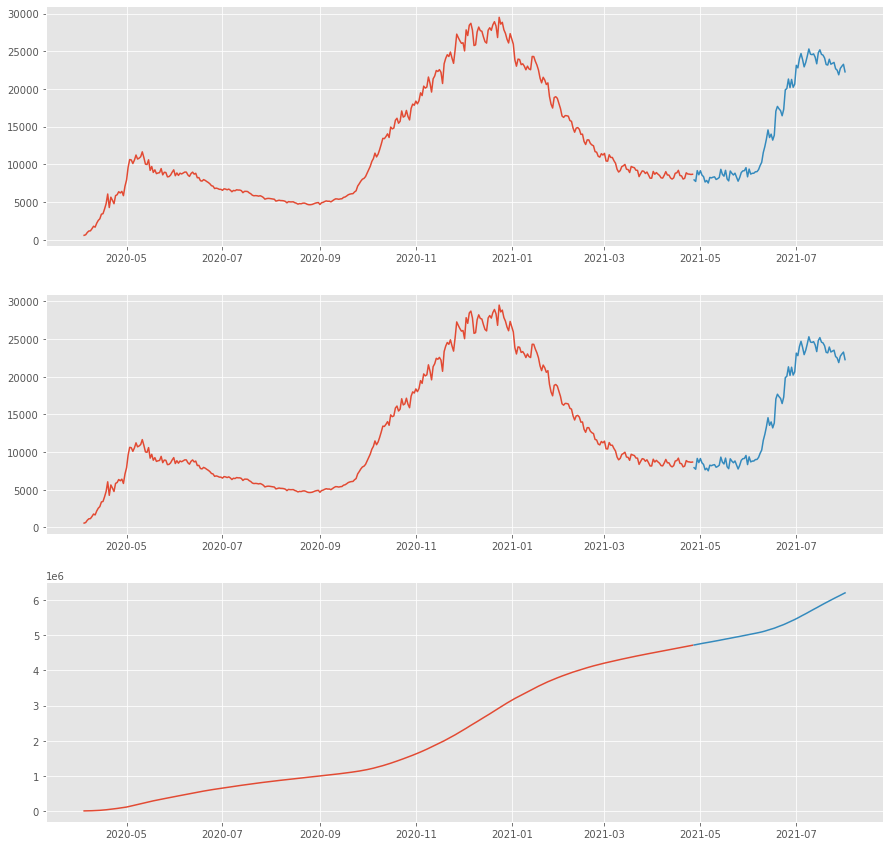

In [51]:
df_ru_test=df_ru['conf1'][:round(df_ru.shape[0]*0.8)]
df_ru_train=df_ru['conf1'][round(df_ru.shape[0]*0.8):]

fig, axs = plt.subplots(3)
axs[0].plot(df_ru_test)
axs[0].plot(df_ru_train)

from sklearn.model_selection import train_test_split
tts_train, tts_test = train_test_split(df_ru['conf1'], test_size = 0.2, shuffle=False)
axs[1].plot(tts_train)
axs[1].plot(tts_test)

tts1_train, tts1_test = train_test_split(df_ru['Confirmed'], test_size = 0.2, shuffle=False)
axs[2].plot(tts1_train)
axs[2].plot(tts1_test)

## Раздел 3. Модели. Прогнозирование временных рядов (60 баллов и 58 бонусных баллов)


В этой третьей и последней части домашнего задания вам предстоит построить несколько моделей и осуществить прогнозирование для временных рядов. Прогнозирование будем делать для такого показателя как летальность от вируса. Летальность можно рассчитывать по формуле:

$$ CFR = \frac{Deaths}{Confirmed} $$

Для каждого типа модели сделайте несколько прогнозов для не менее 3 разных стран/регионов/другое (на ваш обоснованный выбор). Главное, чтобы каждый из типов моделей прознозировал одинаковый набор данных, чтобы в конце можно было сделать выводы о качестве работы той или иной модели.

В качестве метрики качества взять RMSE.

Таким образом, по итогу построения и применения **каждой из моделей** должно быть следующее:
- Вывести массив прогнозов значений (массив имеет размер test-выборки)
- Визуализировать на графике значения ряда из train-выборки одним цветом и прогнозные значения модели (из массива прогнозов) другим цветом, на одних осях
- Визуализировать на графике значения всего ряда (и из train, и из test-выборок) одним цветом и прогнозные значения модели другим цветом, на одних осях (то есть по прогнозным значениям идет наложение двух графиков - подробнее см. в семинаре 5)
- Подсчитать метрику качества по test-выборке
- Добавить результаты метрики качества в общую сводную табличку (по строкам - название модели, по столбцам - RMSE для каждого из рядов - подробнее см. в семинаре 5)

*Примечание. Данный алгоритм необходимо повторять для каждой модели, учитывая разные параметры. Иными словами ARIMA(1,0,1) и ARIMA(2,0,1) - это разные модели*

Не забывайте обязательно сопровождать ваш код комментариями, графиками и выводами.

#### 3.1. Прогнозирование средним (Mean Constant Model)  (5 баллов)

Осуществите простое прогнозирование средним значением

In [52]:
df['CFR']=df['Deaths']/df['Confirmed']
df.head(1)

,Date,Country/Region,Confirmed,Recovered,Deaths,Continent,Population,From_date,CFR
70,2020-04-01,Afghanistan,192,5.00,4,Asia,41128771.00,37 days 00:00:00,0.02


In [53]:
df_ger=pd.DataFrame(df[df['Country/Region']=='Germany'].set_index('Date')['CFR'])
df_ger.head(5)

,CFR
Date,
2020-04-01,0.01
2020-04-02,0.01
2020-04-03,0.01
2020-04-04,0.01
2020-04-05,0.01


In [54]:
df_ger_train, df_ger_test=train_test_split(df_ger, test_size = 0.2, shuffle=False)

Прогноз

In [55]:
from sklearn.metrics import mean_squared_error

In [56]:
mean_value=df_ger_train.mean()
mean_value

CFR   0.03
dtype: float64

In [57]:
x_pred=df_ger_test.index

In [58]:
y_pred=np.ones(x_pred.shape[0])*float(mean_value)

In [59]:
rsme=np.sqrt(mean_squared_error(y_pred, df_ger_test.values))

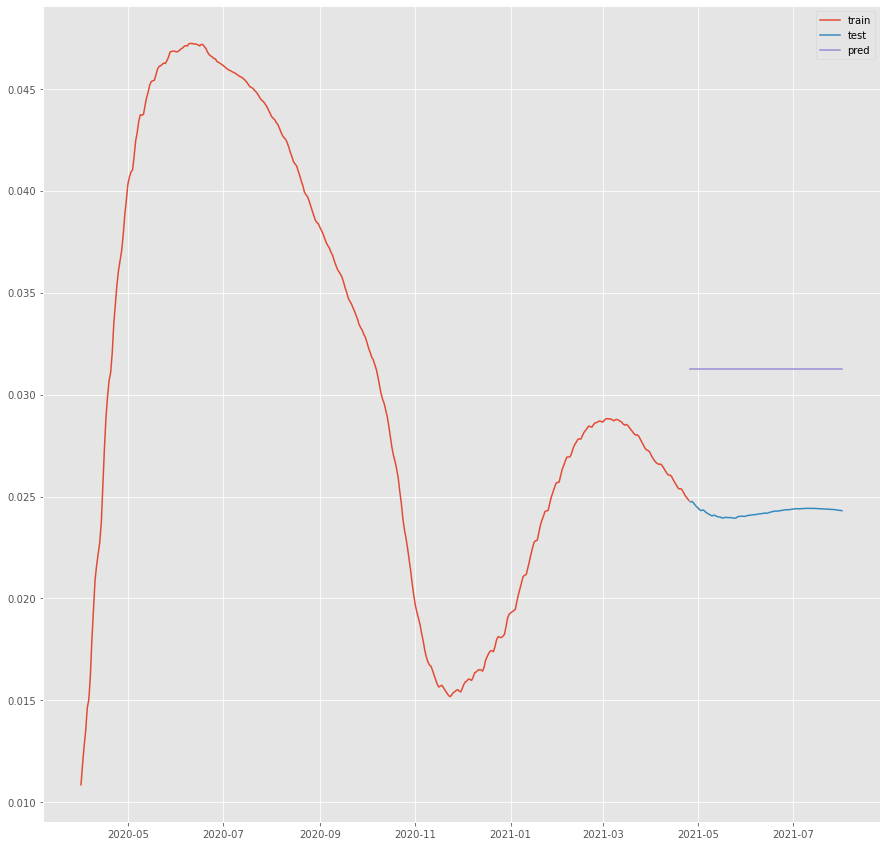

In [60]:
plt.plot(df_ger_train, label='train')
plt.plot(df_ger_test, label='test')
plt.plot(x_pred, y_pred, label='pred')
plt.legend()

#### 3.2. Линейная модель (Linear Trend Model) (5 баллов)

Осуществите предсказание с помощью линейного тренда

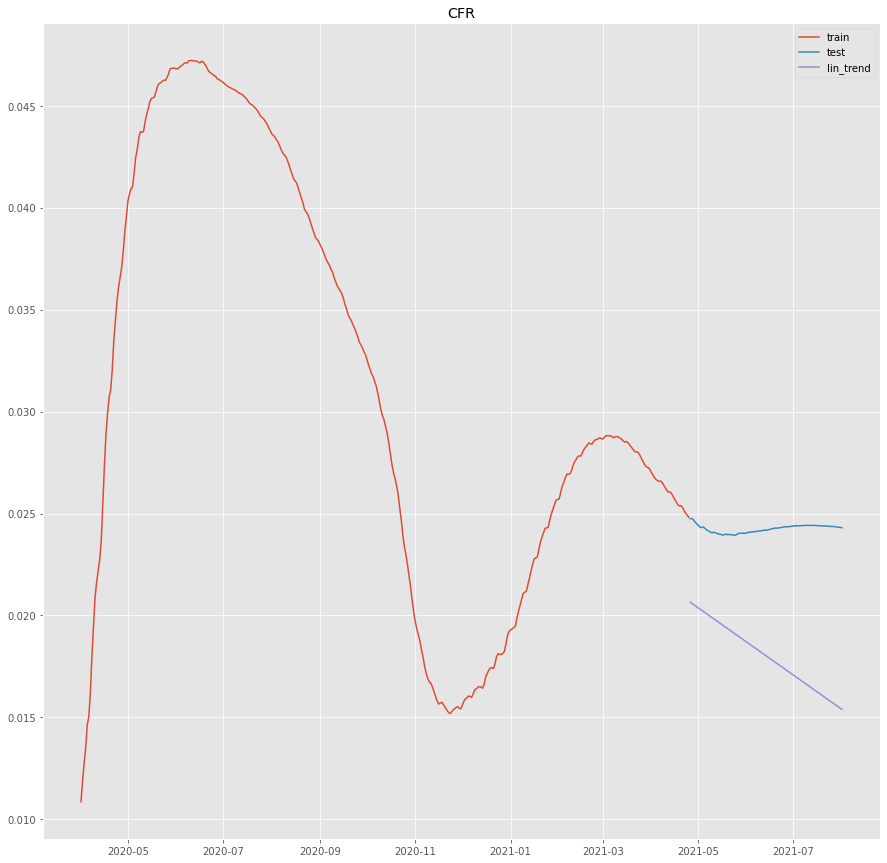

In [61]:
x=[x_ for x_ in range(df_ger_train.shape[0])]
x1=[x_ for x_ in range(df_ger_train.shape[0], df_ger_train.shape[0]+df_ger_test.shape[0])]

y=df_ger_train['CFR']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
p_y=p(x1)
plt.title('CFR')

plt.plot(df_ger_train, label='train')
plt.plot(df_ger_test, label='test')
plt.plot(x_pred, p_y, label='lin_trend')

plt.legend()

#### 3.3. Скользящее среднее (MA - Moving average) (5 баллов)

Постройте предсказание с помощью модели MA. Обязательно поэкспериментируйте с гиперпараметрами модели (и опишите, что вы делаете)

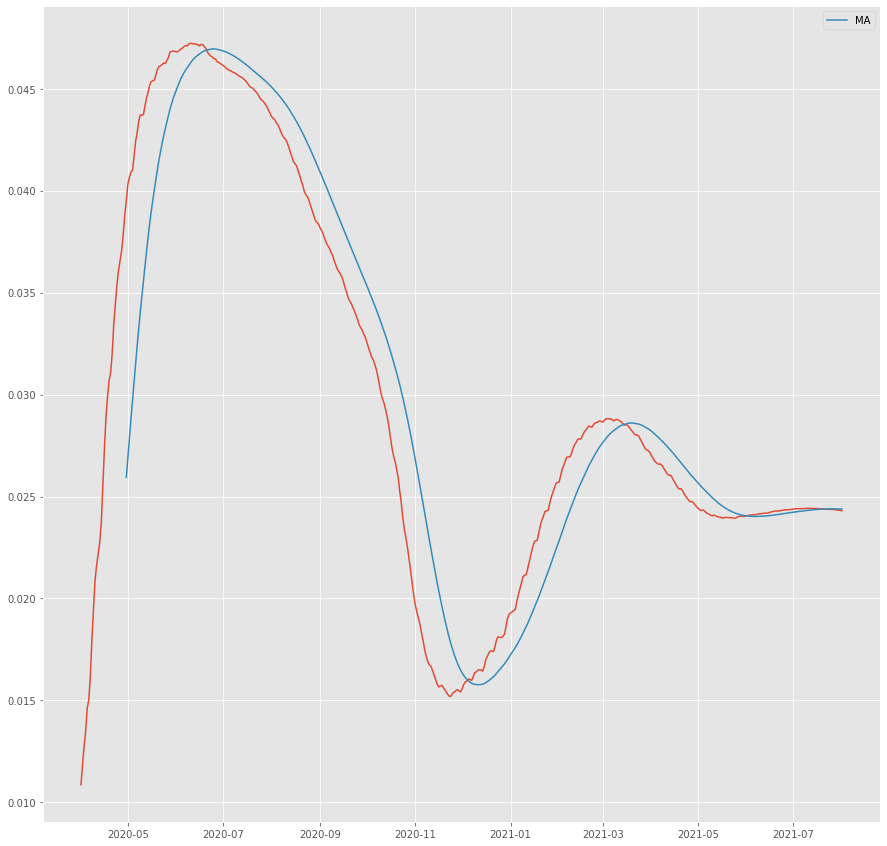

In [62]:
df_ger['SMA30'] = df_ger['CFR'].rolling(30).mean()
plt.plot(df_ger['CFR'])
plt.plot(df_ger['SMA30'], label='MA')
plt.legend()

#### 3.4. Авторегрессионная модель (AR - Autoregressive model) (5 баллов)

Постройте предсказание с помощью модели AR. Обязательно поэкспериментируйте с гиперпараметрами модели (и опишите, что вы делаете)

In [63]:
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(df_ger_train, lags=8).fit()

pred = ar_model.predict(start=len(df_ger_train), end=(len(df_ger)-1), dynamic=False)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


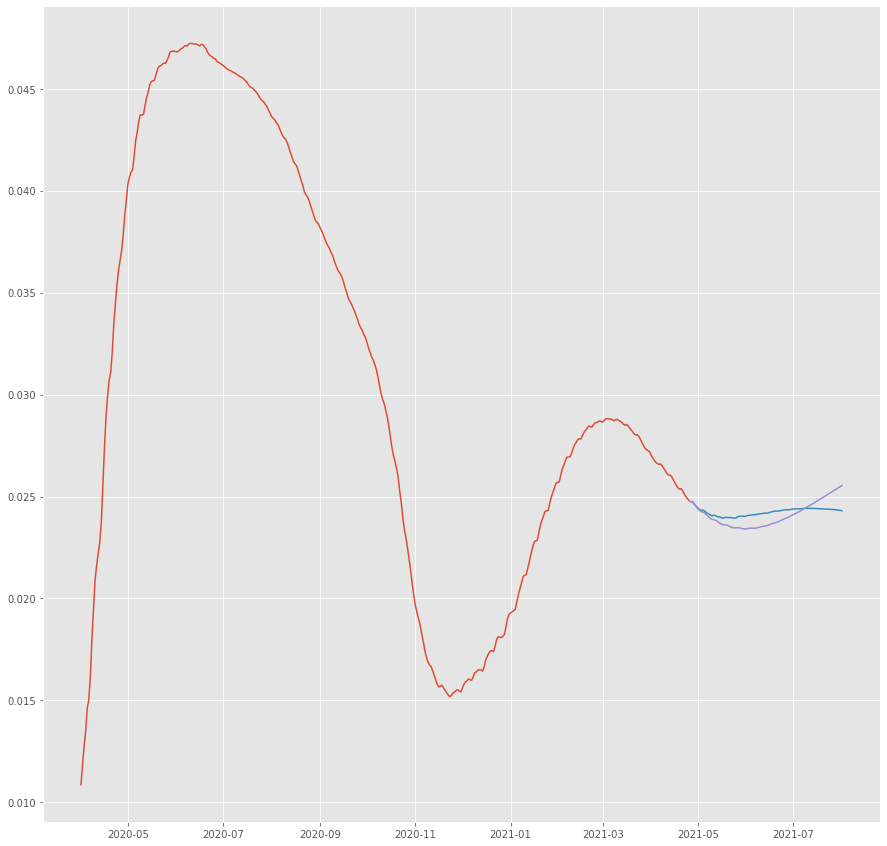

In [64]:
plt.plot(df_ger_train, label='train')
plt.plot(df_ger_test, label='test')
plt.plot(pred, label='pred')

#### 3.5. ARMA (5 баллов)

Постройте предсказание, скомбинировав модели AR и MA. Обязательно поэкспериментируйте с гиперпараметрами модели (и опишите, что вы делаете)

In [65]:
df_ger_train

,CFR
Date,
2020-04-01,0.01
2020-04-02,0.01
2020-04-03,0.01
2020-04-04,0.01
2020-04-05,0.01
...,...
2021-04-21,0.03
2021-04-22,0.03
2021-04-23,0.03


In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
ARMAmodel = SARIMAX(df_ger_train)
ARMAmodel = ARMAmodel.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [67]:
ARMAmodel.predict()

2020-04-01   0.00
2020-04-02   0.01
2020-04-03   0.01
2020-04-04   0.01
2020-04-05   0.01
             ... 
2021-04-21   0.03
2021-04-22   0.03
2021-04-23   0.03
2021-04-24   0.03
2021-04-25   0.02
Freq: D, Name: predicted_mean, Length: 390, dtype: float64

#### 3.6. Интегрированная модель авторегрессии — скользящего среднего (Auto Regressive Integrated Moving Average) - ARIMA (5 баллов)

Постройте предсказание, модернизировав модель ARMA и добавив интегрирующую компоненту. Обязательно поэкспериментируйте с гиперпараметрами модели (и опишите, что вы делаете)

In [68]:
# Ваш код здесь

#### 3.7. SARIMA (Seasonal Auto Regressive Integrated Moving Average) (5 баллов и 5 бонусных баллов)

Постройте предсказание, модернизировав модель ARIMA и добавив сезонную составляющую. Обязательно поэкспериментируйте с гиперпараметрами модели (и опишите, что вы делаете).

Бонусные баллы за это задание выставляются как совокупность за все задания по классам SARIMA (3.3 - 3.7), в случае если ваши модели получились хорошие, точные и вы верно настроили гиперпараметры, хорошо описав ваши действия.

*Примечание. Вы можете также почитать про Алгоритм Хиндмана-Хандакара для настройки SARIMA. Возможно, он сможет вам помочь и улучшить качество моделей*

In [69]:
# Ваш код здесь

#### 3.8. ETS - Экспоненциальное сглаживание (Exponential smoothing) (15 баллов и 15 бонусных баллов)

Задание на основные баллы:

- Поработайте с классом моделей ETS (Exponential smoothing), подробно рассматривавшемся на лекции. Примените ETS(ANN), ETS(AAA) и еще минимум 3 любые (на ваш выбор) модели ETS. Осуществите настройку гиперпараметров во всех моделях. Сравните результаты между ними. Попробуйте объяснить, почему модели показывают такие результаты и такую разницу в результатах. Сделайте выводы.

Задания на бонусные баллы:

- Попробуйте теперь обучить ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`). Что делает этот алгоритм? Что такое AIC? Какие результаты получаются? Сделайте выводы.

- Попробуйте также применить Double exponential smoothing и Triple exponential smoothing. Что это за модели? Какие результаты показывают они? Почему? Сделайте выводы.

- Нарисуйте для наилучшей модели предсказания **с доверительным интервалом** (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель не выдает доверительные интервалы сразу, но при желании до них можно дотянуться!

In [70]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [71]:
from sktime.datasets import load_airline
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
y = load_airline()
pd.DataFrame(y)
# forecaster = ExponentialSmoothing(
#     trend='add', seasonal='multiplicative', sp=12
# )  
# forecaster.fit(y)  
# y_pred = forecaster.predict(fh=[1,2,3])
# y.plot()
# y_pred.plot()

,Number of airline passengers
Period,
1949-01,112.00
1949-02,118.00
1949-03,132.00
1949-04,129.00
1949-05,121.00
...,...
1960-08,606.00
1960-09,508.00
1960-10,461.00


In [72]:
df_ger_train=df_ger_train.asfreq(freq='D')

In [73]:
forecaster = ExponentialSmoothing(trend='add', seasonal='multiplicative')  
forecaster.fit(df_ger_train)
y_pred=forecaster.predict(df_ger_test.asfreq(freq='D').index)

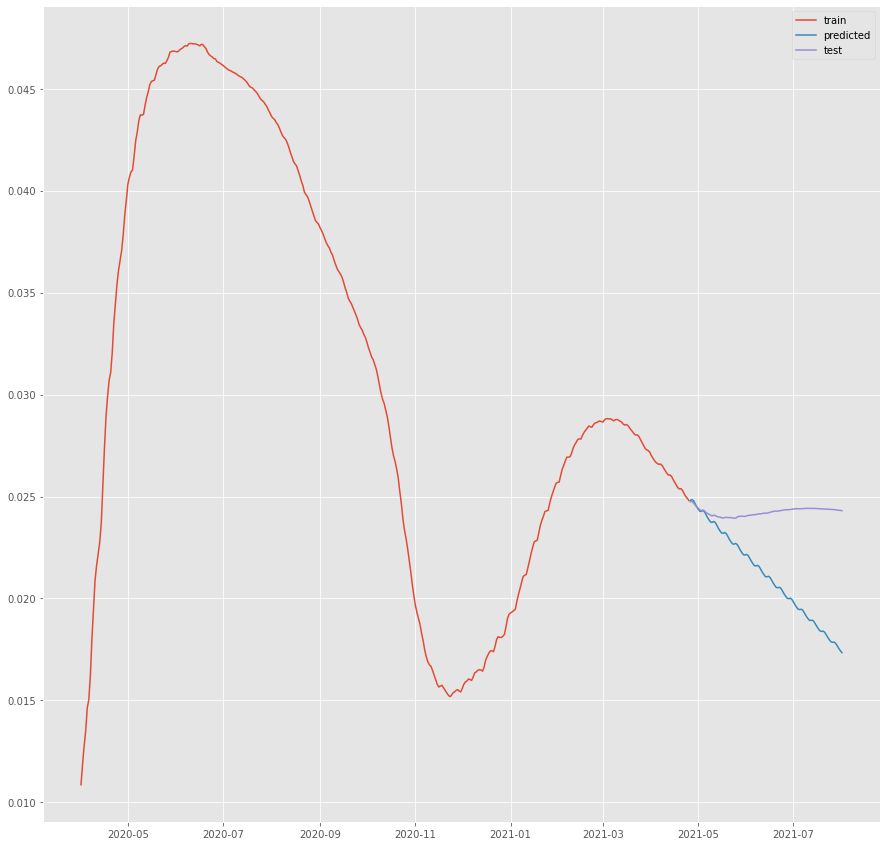

In [74]:
plt.plot(df_ger_train, label='train')
plt.plot(y_pred, label='predicted')
plt.plot(df_ger_test, label='test')
plt.legend()

#### 3.9. KTR из orbit (8 бонусных баллов).

Попробуйте использовать модель KTR из библиотеки orbit для предсказания временных рядов.



In [75]:
from orbit.models.ktrlite import KTRLite

In [76]:
df_ger_train.reset_index(inplace=True)

In [77]:
ktrlite1=KTRLite(response_col='CFR', date_col='Date')

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


In [78]:
ktrlite1.fit(df=df_ger_train)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6ea95f5d2ae85eb1bcb07ba2b0042aff NOW.


CompileError: command 'C:\\Program Files\\Microsoft Visual Studio\\2022\\Community\\VC\\Tools\\MSVC\\14.31.31103\\bin\\HostX86\\x64\\cl.exe' failed with exit code 2

In [ ]:
pred=ktrlite1.predict(df_ger_test)
pred

#### 3.10. Библиотека Prophet (10 бонусных баллов)
Попробуйте использовать библиотеку Prophet для предсказания временных рядов. [Документация](https://facebook.github.io/prophet/docs/quick_start.html).

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.


In [ ]:
from prophet import Prophet

In [ ]:
m = Prophet()
df_ger_train=df_ger_train.rename(columns={'Date': 'ds', 'CFR': 'y'})
m.fit(df_ger_train)
future = m.make_future_dataframe(periods=365)

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig2 = m.plot_components(forecast)

#### 3.11 Линейная модель с регрессией (Linear Regression Model) (5 баллов и 10 бонусных баллов)

Примените линейную модель с регрессией для предсказания временных рядов.
Какие признаки оказались наиболее значимыми? Почему? Как вы это интерпретируете? Какие выводы можно сделать?

*Примечание. Это задание идет в тесной связке с заданием 1.8.*



In [ ]:
from sklearn.linear_model import LinearRegression
linreg=LinearRegression()
y=df_ger_train['y']
X=np.reshape(np.arange(0, df_ger_train.shape[0]), (df_ger_train.shape[0],1))
linreg.fit(X, y)

In [ ]:
X_test=np.reshape(np.arange(df_ger_train.shape[0], df_ger_train.shape[0]+df_ger_test.shape[0]), (df_ger_test.shape[0],1))
y_pred=linreg.predict(X_test)

In [ ]:
plt.plot(df_ger_train['ds'], df_ger_train['y'])
plt.plot(df_ger_test)
plt.plot(df_ger_test.index, y_pred)

#### 3.12. Дополнительная модель (10 бонусных баллов)

Используйте еще одну какую-нибудь любую другую известную вам модель для предсказания временных рядов и заработайте дополнительные бонусные баллы!

In [ ]:
!pip install mxnet==1.9
# А еще надо поставить autogluon

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

ts_dataframe = TimeSeriesDataFrame.from_data_frame(
    df_ger_train,
    #id_column="y",  # column that contains unique ID of each time series
    timestamp_column="ds",  # column that contains timestamps of each observation
)

#### 3.13 Выводы (5 баллов)

Выведите все построенные вами модели на одних осях. Выведите общую сравнительную табличку по всем моделям, которые вы оценивали. Какие выводы вы можете сделать? Какая модель показала себя лучше всего? Как вы думаете почему? Одинаковые ли результаты эффективности получились у моделей на разных временных рядах? Какие итоги вы можете подвести по сравнению моделей друг с другом?


<здесь место для ваших выводов>

## Выводы по работе (5 баллов)

Напишите итоговые выводы по всему проделанному исследованию. С какими данными (временными рядами) вам понравилось работать, а с какими нет? Какие модели показались вам простыми и удобными, а какие менее понравились? Выявили ли вы какие-то закономерности в применимости моделей? Если в ходе работы, вы пробовали где-то разные варианты, разные подходы, и это не попало в описание предыдущих действий, опишите их тут. Что можно сказать в целом о том, как мы решили задачу, изначально поставленную перед нами? Подведите окончательные итоги

Вывод:
Понравились модели требующие минимального вмешательства, не требующие каких-то дополнительных библиотек. Простые модели тоже не понравились в силу их примитивности. В целом в такого рода исследованиях предпочитаю autoML системы, типа autogluon.